##### Copyright 2023 The MediaPipe Authors. All Rights Reserved.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Hand Landmarks Detection with MediaPipe Tasks

This notebook shows you how to use MediaPipe Tasks Python API to detect hand landmarks from images.

## Preparation

Let's start with installing MediaPipe.

In [1]:
!pip install -q mediapipe

^C
ERROR: Operation cancelled by user


Then download an off-the-shelf model bundle. Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/hand_landmarker#models) for more information about this model bundle.

In [2]:
!wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task

## Visualization utilities

In [12]:
#@markdown We implemented some functions to visualize the hand landmark detection results. <br/> Run the following cell to activate the functions.

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
from typing import List, Mapping, Optional, Tuple, Union

MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

_PRESENCE_THRESHOLD = 0.5
_VISIBILITY_THRESHOLD = 0.5
_BGR_CHANNELS = 3

WHITE_COLOR = (224, 224, 224)
BLACK_COLOR = (0, 0, 0)
RED_COLOR = (0, 0, 255)
GREEN_COLOR = (0, 128, 0)
BLUE_COLOR = (255, 0, 0)

class DrawingSpec:
  # Color for drawing the annotation. Default to the white color.
  color: Tuple[int, int, int] = WHITE_COLOR
  # Thickness for drawing the annotation. Default to 2 pixels.
  thickness: int = 2
  # Circle radius. Default to 2 pixels.
  circle_radius: int = 2

def draw_landmarks(
    image: np.ndarray,
    landmark_list: landmark_pb2.NormalizedLandmarkList,
    connections: Optional[List[Tuple[int, int]]] = None,
    landmark_drawing_spec: Optional[
        Union[DrawingSpec, Mapping[int, DrawingSpec]]
    ] = DrawingSpec(color=RED_COLOR),
    connection_drawing_spec: Union[
        DrawingSpec, Mapping[Tuple[int, int], DrawingSpec]
    ] = DrawingSpec(),
    is_drawing_landmarks: bool = True,
):
  """Draws the landmarks and the connections on the image.

  Args:
    image: A three channel BGR image represented as numpy ndarray.
    landmark_list: A normalized landmark list proto message to be annotated on
      the image.
    connections: A list of landmark index tuples that specifies how landmarks to
      be connected in the drawing.
    landmark_drawing_spec: Either a DrawingSpec object or a mapping from hand
      landmarks to the DrawingSpecs that specifies the landmarks' drawing
      settings such as color, line thickness, and circle radius. If this
      argument is explicitly set to None, no landmarks will be drawn.
    connection_drawing_spec: Either a DrawingSpec object or a mapping from hand
      connections to the DrawingSpecs that specifies the connections' drawing
      settings such as color and line thickness. If this argument is explicitly
      set to None, no landmark connections will be drawn.
    is_drawing_landmarks: Whether to draw landmarks. If set false, skip drawing
      landmarks, only contours will be drawed.

  Raises:
    ValueError: If one of the followings:
      a) If the input image is not three channel BGR.
      b) If any connetions contain invalid landmark index.
  """
  if not landmark_list:
    return
  if image.shape[2] != _BGR_CHANNELS:
    raise ValueError('Input image must contain three channel bgr data.')
  image_rows, image_cols, _ = image.shape
  idx_to_coordinates = {}
  for idx, landmark in enumerate(landmark_list.landmark):
    if ((landmark.HasField('visibility') and
         landmark.visibility < _VISIBILITY_THRESHOLD) or
        (landmark.HasField('presence') and
         landmark.presence < _PRESENCE_THRESHOLD)):
      continue
    landmark_px = _normalized_to_pixel_coordinates(landmark.x, landmark.y,
                                                   image_cols, image_rows)
    if landmark_px:
      idx_to_coordinates[idx] = landmark_px
  if connections:
    num_landmarks = len(landmark_list.landmark)
    # Draws the connections if the start and end landmarks are both visible.
    for connection in connections:
      start_idx = connection[0]
      end_idx = connection[1]
      if not (0 <= start_idx < num_landmarks and 0 <= end_idx < num_landmarks):
        raise ValueError(f'Landmark index is out of range. Invalid connection '
                         f'from landmark #{start_idx} to landmark #{end_idx}.')
      if start_idx in idx_to_coordinates and end_idx in idx_to_coordinates:
        drawing_spec = connection_drawing_spec[connection] if isinstance(
            connection_drawing_spec, Mapping) else connection_drawing_spec
        cv2.line(image, idx_to_coordinates[start_idx],
                 idx_to_coordinates[end_idx], drawing_spec.color,
                 drawing_spec.thickness)
  # Draws landmark points after finishing the connection lines, which is
  # aesthetically better.
  if is_drawing_landmarks and landmark_drawing_spec:
    for idx, landmark_px in idx_to_coordinates.items():
      drawing_spec = landmark_drawing_spec[idx] if isinstance(
          landmark_drawing_spec, Mapping) else landmark_drawing_spec
      # White circle border
      circle_border_radius = max(drawing_spec.circle_radius + 1,
                                 int(drawing_spec.circle_radius * 1.2))
      cv2.circle(image, landmark_px, circle_border_radius, WHITE_COLOR,
                 drawing_spec.thickness)
      # Fill color into the circle
      cv2.circle(image, landmark_px, drawing_spec.circle_radius,
                 drawing_spec.color, drawing_spec.thickness)

def draw_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"{handedness[0].category_name}",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

TypeError: DrawingSpec() takes no arguments

## Download test image

Let's grab a test image that we'll use later. The image is from [Unsplash](https://unsplash.com/photos/mt2fyrdXxzk).

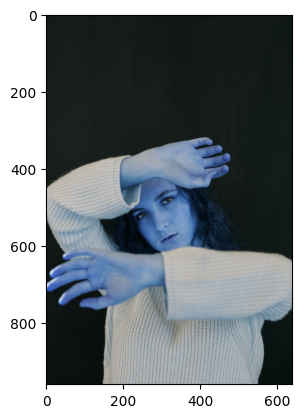

In [2]:
!wget -q -O image.jpg https://storage.googleapis.com/mediapipe-tasks/hand_landmarker/woman_hands.jpg

import cv2
from matplotlib.pyplot import imshow

img = cv2.imread("image.jpg")
imshow(img)

In [3]:
detection_result

NameError: name 'detection_result' is not defined

Optionally, you can upload your own image. If you want to do so, uncomment and run the cell below.

## Running inference and visualizing the results

Here are the steps to run hand landmark detection using MediaPipe.

Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/hand_landmarker/python) to learn more about configuration options that this solution supports.


<class 'mediapipe.python._framework_bindings.image.Image'>
(960, 640, 4)


I0000 00:00:1725971251.732297 236127565 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1725971251.774268 236128755 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725971251.798337 236128761 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725971251.848272 236128756 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
/Users/sriramjeyakumar/miniconda3/envs/llm/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype(

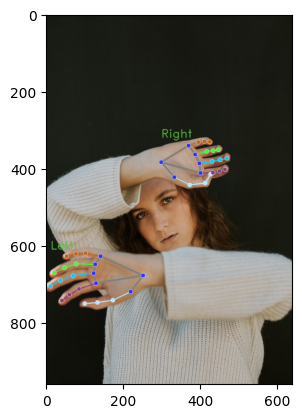

In [4]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an HandLandmarker object.
base_options = python.BaseOptions(model_asset_path='models/hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("image.jpg")
print(type(image))
# STEP 4: Detect hand landmarks from the input image.
detection_result = detector.detect(image)
print(image.numpy_view().shape)

# STEP 5: Process the classification result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view()[:,:,:3], detection_result)
imshow(annotated_image)

In [6]:
dir(detection_result)

['__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__match_args__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'hand_landmarks',
 'hand_world_landmarks',
 'handedness']

In [7]:
detection_result.hand_landmarks

[[NormalizedLandmark(x=0.39291882514953613, y=0.7066094279289246, z=-3.2929972348938463e-07, visibility=0.0, presence=0.0),
  NormalizedLandmark(x=0.3431203365325928, y=0.7504481077194214, z=-0.01982179656624794, visibility=0.0, presence=0.0),
  NormalizedLandmark(x=0.27089524269104004, y=0.7737333178520203, z=-0.02736632153391838, visibility=0.0, presence=0.0),
  NormalizedLandmark(x=0.2080773562192917, y=0.779670238494873, z=-0.036947671324014664, visibility=0.0, presence=0.0),
  NormalizedLandmark(x=0.15704932808876038, y=0.7829773426055908, z=-0.04580814763903618, visibility=0.0, presence=0.0),
  NormalizedLandmark(x=0.20208586752414703, y=0.7279685139656067, z=0.004852598067373037, visibility=0.0, presence=0.0),
  NormalizedLandmark(x=0.13295283913612366, y=0.7431300282478333, z=-0.01850847527384758, visibility=0.0, presence=0.0),
  NormalizedLandmark(x=0.09457875043153763, y=0.7587483525276184, z=-0.042702510952949524, visibility=0.0, presence=0.0),
  NormalizedLandmark(x=0.06427

In [9]:
dir(mp.Image)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'channels',
 'create_from_file',
 'height',
 'image_format',
 'is_aligned',
 'is_contiguous',
 'is_empty',
 'numpy_view',
 'step',
 'uses_gpu',
 'width']

In [12]:
image = cv2.imread("image.jpg")

mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)

In [13]:

detection_result = detector.detect(mp_image)

/Users/sriramjeyakumar/miniconda3/envs/llm/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


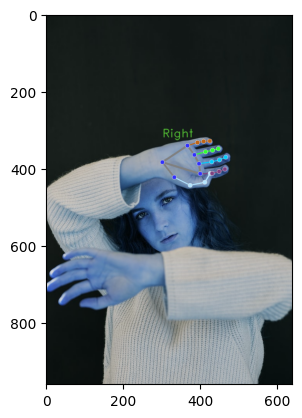

In [14]:
annotated_image = draw_landmarks_on_image(mp_image.numpy_view()[:,:,:3], detection_result)
imshow(annotated_image)

In [2]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import numpy as np
from tqdm import tqdm
import cv2
import os

MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54)  # vibrant green

directory = "data/train/A"


# Utility function to draw a rectangle around a region of interest
def draw_landmarks_on_image(rgb_image, detection_result):
    hand_landmarks_list = detection_result.hand_landmarks
    handedness_list = detection_result.handedness
    annotated_image = np.copy(rgb_image)

    # Loop through the detected hands to visualize.
    for idx in range(len(hand_landmarks_list)):
        hand_landmarks = hand_landmarks_list[idx]
        handedness = handedness_list[idx]

        # Draw the hand landmarks.
        hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        hand_landmarks_proto.landmark.extend(
            [
                landmark_pb2.NormalizedLandmark(
                    x=landmark.x, y=landmark.y, z=landmark.z
                )
                for landmark in hand_landmarks
            ]
        )
        solutions.drawing_utils.draw_landmarks(
            annotated_image,
            hand_landmarks_proto,
            solutions.hands.HAND_CONNECTIONS,
            solutions.drawing_styles.get_default_hand_landmarks_style(),
            solutions.drawing_styles.get_default_hand_connections_style(),
        )

        # Get the top left corner of the detected hand's bounding box.
        height, width, _ = annotated_image.shape
        x_coordinates = [landmark.x for landmark in hand_landmarks]
        y_coordinates = [landmark.y for landmark in hand_landmarks]
        text_x = int(min(x_coordinates) * width)
        text_y = int(min(y_coordinates) * height) - MARGIN

        # Draw handedness (left or right hand) on the image.
        cv2.putText(
            annotated_image,
            f"{handedness[0].category_name}",
            (text_x, text_y),
            cv2.FONT_HERSHEY_DUPLEX,
            FONT_SIZE,
            HANDEDNESS_TEXT_COLOR,
            FONT_THICKNESS,
            cv2.LINE_AA,
        )

    return annotated_image


base_options = python.BaseOptions(model_asset_path="hand_landmarker.task")
options = vision.HandLandmarkerOptions(base_options=base_options, num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

I0000 00:00:1726369756.254627 1058759 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1726369756.291254 1109233 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1726369756.315266 1109235 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [5]:
img = cv2.imread("data/train/A/12.jpg")
mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=img)
detection_result = detector.detect(mp_image)
annotated_image = draw_landmarks_on_image(mp_image.numpy_view()[:,:,:3], detection_result)

/Users/sriramjeyakumar/miniconda3/envs/llm/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [6]:
detection_result.hand_landmarks

[[NormalizedLandmark(x=0.4033717215061188, y=0.6613288521766663, z=-2.212543108726095e-07, visibility=0.0, presence=0.0),
  NormalizedLandmark(x=0.47962912917137146, y=0.658263623714447, z=-0.0638618990778923, visibility=0.0, presence=0.0),
  NormalizedLandmark(x=0.5481176376342773, y=0.5941521525382996, z=-0.09039764851331711, visibility=0.0, presence=0.0),
  NormalizedLandmark(x=0.5831782221794128, y=0.5168482661247253, z=-0.10933855921030045, visibility=0.0, presence=0.0),
  NormalizedLandmark(x=0.6236699819564819, y=0.4662911295890808, z=-0.11857078224420547, visibility=0.0, presence=0.0),
  NormalizedLandmark(x=0.5511802434921265, y=0.49204856157302856, z=-0.03878120705485344, visibility=0.0, presence=0.0),
  NormalizedLandmark(x=0.5397893190383911, y=0.45021694898605347, z=-0.09893861413002014, visibility=0.0, presence=0.0),
  NormalizedLandmark(x=0.5071231126785278, y=0.5178234577178955, z=-0.12604179978370667, visibility=0.0, presence=0.0),
  NormalizedLandmark(x=0.498206377029

In [10]:
detection_result.hand_landmarks[0][0].x

0.4033717215061188

In [16]:
output_dict = {}

In [17]:
for i in range(21):
    output_dict[f"kp_{i}_x"] = detection_result.hand_landmarks[0][i].x
    output_dict[f"kp_{i}_y"] = detection_result.hand_landmarks[0][i].y

In [18]:
output_dict

{'kp_0_x': 0.4033717215061188,
 'kp_0_y': 0.6613288521766663,
 'kp_1_x': 0.47962912917137146,
 'kp_1_y': 0.658263623714447,
 'kp_2_x': 0.5481176376342773,
 'kp_2_y': 0.5941521525382996,
 'kp_3_x': 0.5831782221794128,
 'kp_3_y': 0.5168482661247253,
 'kp_4_x': 0.6236699819564819,
 'kp_4_y': 0.4662911295890808,
 'kp_5_x': 0.5511802434921265,
 'kp_5_y': 0.49204856157302856,
 'kp_6_x': 0.5397893190383911,
 'kp_6_y': 0.45021694898605347,
 'kp_7_x': 0.5071231126785278,
 'kp_7_y': 0.5178234577178955,
 'kp_8_x': 0.49820637702941895,
 'kp_8_y': 0.5559682250022888,
 'kp_9_x': 0.48955145478248596,
 'kp_9_y': 0.4790876507759094,
 'kp_10_x': 0.4753879904747009,
 'kp_10_y': 0.43666231632232666,
 'kp_11_x': 0.45378056168556213,
 'kp_11_y': 0.5243164300918579,
 'kp_12_x': 0.4571240544319153,
 'kp_12_y': 0.5623434782028198,
 'kp_13_x': 0.43299293518066406,
 'kp_13_y': 0.480099081993103,
 'kp_14_x': 0.4135969877243042,
 'kp_14_y': 0.45722997188568115,
 'kp_15_x': 0.4044424891471863,
 'kp_15_y': 0.5399938